# Example use of implemented conductance models

This notebook shows how we create Figure 3 in the code paper (The Lompe code: A Python Toolbox for
Ionospheric Data Analysis). The conductances are calculated using the implementations of:

- The [Hardy et al. (1987)](https://doi.org/10.1029/JA092iA11p12275) model for auroral contribution to conductances.
- A novel method to calculate the solar extreme ultraviolet (EUV) contribution to the ionospheric conductance (the method is described in Section 2.4 in [Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). 

We start by importing relevant modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import lompe
from lompe.utils.conductance import *

Re = 6371.2e3    # Earth radius

We set up a grid of magnetic latitude and magnetic local time (MLT) coordinates covering a large portion of the high-latitude northern hemisphere:

In [2]:
mlats = np.linspace(53,90,37)
mlts = np.linspace(0,24,72)
mlat, mlt = np.meshgrid(mlats, mlts, indexing = 'xy')

We can then use the hardy_EUV function to get the conductances on the entire grid:

In [3]:
time = dt.datetime(2014, 9, 10) # date is used for coordinate conversion and to get solar zenith angles (sza)
Kp   = 4    #      for Hardy model
F107 = 100  # sfu, for EUV conductance
refh = 110  # km,  for coodinate conversion

# coordinates are converted to geographic system
a = Apex(time, refh)
mlon = a.mlt2mlon(mlt, time)
lat, lon, _ = a.apex2geo(mlat, mlon, refh)

# Hall and Pedersen conductances
SH, SP = hardy_EUV(lon.flatten(), lat.flatten(), Kp, time, 'hp', F107, refh = refh)

The hardy_EUV method can also return only the Hall, or only the Pedersen conductance by specifying the *hall_or_pedersen* parameter to '*hall*' or '*pedersen*' only. An additional input parameter of *calibration* can be given, which is relevant for how the EUV contribution to the conductances is calculated (will be investigated further in the last section in this notebook).

### Polarsubplot for visualization

We can illustrate how the ionospheric conductances look on the nortern hemisphere using the polarsubplot class. Polarsubplot objects handle plotting in polar coordinates, specifically an magnetic latitude/MLT grid (or similar).

In [50]:
def make_cond_figure(mlat, mlt, SH, SP, levels = np.linspace(0,20,20), ticks=np.linspace(0,20,5), savefig = False, header=None):
    
    # set up figure and axes
    fig = plt.figure(figsize = (11,5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    ax1.set_title('Hall',     y = 1, fontsize = 16)
    ax2.set_title('Pedersen', y = 1, fontsize = 16)

    # initialize polarsubplot objects
    polplot1 = lompe.model.visualization.Polarsubplot(ax1, minlat = 50, plotgrid = True, sector = 'all')
    polplot2 = lompe.model.visualization.Polarsubplot(ax2, minlat = 50, plotgrid = True, sector = 'all')
    polplot1.writeMLTlabels(color = 'grey', mlat = 50, fontsize = 12)
    polplot2.writeMLTlabels(color = 'grey', mlat = 50, fontsize = 12)

    # color scales 
    polplot1.contourf(  mlat, mlt, SH.reshape(mlat.shape), cmap='magma', levels=levels, extend='both')
    c=polplot2.contourf(mlat, mlt, SP.reshape(mlat.shape), cmap='magma', levels=levels, extend='both')
    
    # adjust spacing between axes
    plt.subplots_adjust(wspace=0.09, left=0.01, right=1.1, bottom=0 , top=.9)

    # color bar
    fig.colorbar(c, ax=[ax1,ax2], label = '[moh]', ticks=ticks, orientation='vertical', shrink=0.7, aspect=25)
    
    # add header
    if header is not None:
        fig.suptitle(header, fontweight="bold", fontsize=14)

    # save figure
    if savefig:
        fig.savefig('./output_figures/conductanceexample.pdf')
        fig.savefig('./output_figures/conductanceexample.png')

Make figure for ionospheric conductances from hardy_EUV( ):

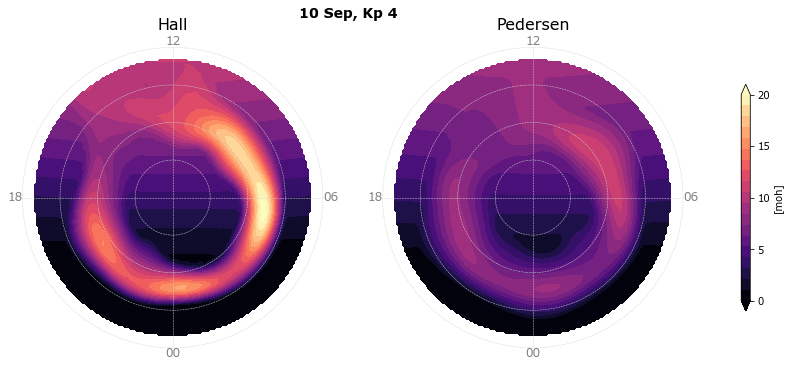

In [51]:
header = time.strftime("%d %b")+""", Kp """+str(Kp) + """                    """
make_cond_figure(mlat, mlt, SH, SP, header=header, savefig=True)

### Hardy model for auroral conductances
    
We can get only the auroral contribution to the ionospheric conductance from the implementation of the Hardy model. This function requires the Kp index, as the Hardy empirical model for the auroral conductances is binned based on Kp. Note that the implementation of the Hardy model requires the locations to be given in magnetic latitude and MLT coordinates.

In [6]:
hardy_hall, hardy_pedersen = hardy(mlat, mlt, Kp, 'hp') # or one or the other using hallOrped ('h' or 'p')

Plot the conductances from hardy( ):

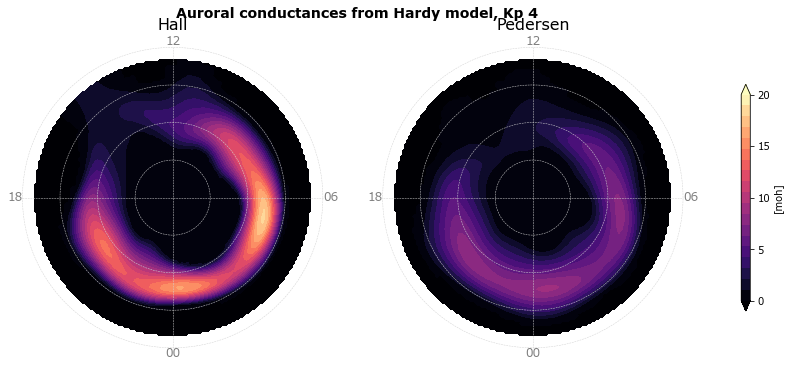

In [52]:
header = """Auroral conductances from Hardy model, Kp """+str(Kp)+"""                """
make_cond_figure(mlat, mlt, hardy_hall, hardy_pedersen, header=header)

### EUV conductances

If we want only the EUV contribution to the conductance, we use the EUV_conductance( ) method directly. This method is based on a modified version of the empirical model from [Moen & Brekke (1993)](https://doi.org/10.1029/92GL02109) where $cos\chi$ is replaced with a function $q'(\chi)$ that specifies the relative maximum production due to solar EUV assuming a radially stratified atmosphere. $\chi$ is the solar zenith angle. A file containing $q'(\chi)$ for all $\chi$ between 0$^\circ$ and 120$^\circ$ (0.1$^\circ$ resolution) stored in the /data/ folder is used for the calculations. With *calibration='Cousinsetal2015'*, a modified version of the emprical conductance model from [Cousins et al. 2015](https://doi.org/10.1002/2014JA020463) is used to calculate the conductances.

To get only solar EUV contribution to the ionospheric conductance:

In [8]:
sza = sunlight.sza(lat, lon, time) # get sza for locations from Lompe utils

EUV_SH, EUV_SP = EUV_conductance(sza, F107, 'hp') # or one or the other using hallOrped ('h' or 'p')

Plot the EUV conductances:

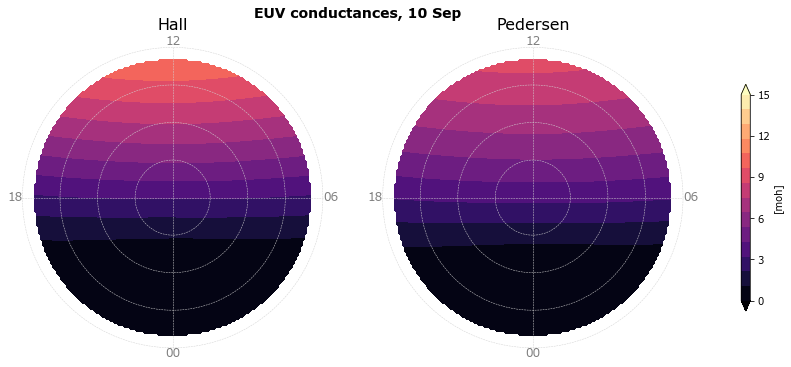

In [53]:
header = """EUV conductances, """+time.strftime("%d %b") + """                """
levels = np.linspace(0,15,15)
ticks  = np.linspace(0,15,6)
make_cond_figure(mlat, mlt, EUV_SH, EUV_SP, levels=levels, ticks=ticks, header=header)

### Example to look at differences in 'calibration'

Different empirical models for the EUV conductance exist, and which *calibration* that is the best can be hard to determine. This has been pointed out by, e.g., [Ieda et al. 2014](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JA020665)) and D. Weimer in a talk titled [Unsolved Problems In Ionospheric Conductivity](http://spacescience.org/workshops/unsolvedproblems2015/presentations/dan_weimer.pdf) held in 2015. Therefore we include at least two alternative empirical models (*calibrations*) in our implementation.

We can compare the different empirical models:

In [10]:
# using the empirical model from Cousins et al. (2015)
SH_C, SP_C     = EUV_conductance(sza, F107, 'hp', calibration = 'Cousinsetal2015'   )
# using the empirical model from Moen & Brekke (1993) but with "alternative calibration"
SH_alt, SP_alt = EUV_conductance(sza, F107, 'hp', calibration = 'MoenBrekke1993_alt')

And plot the EUV conductances for different calibrations:

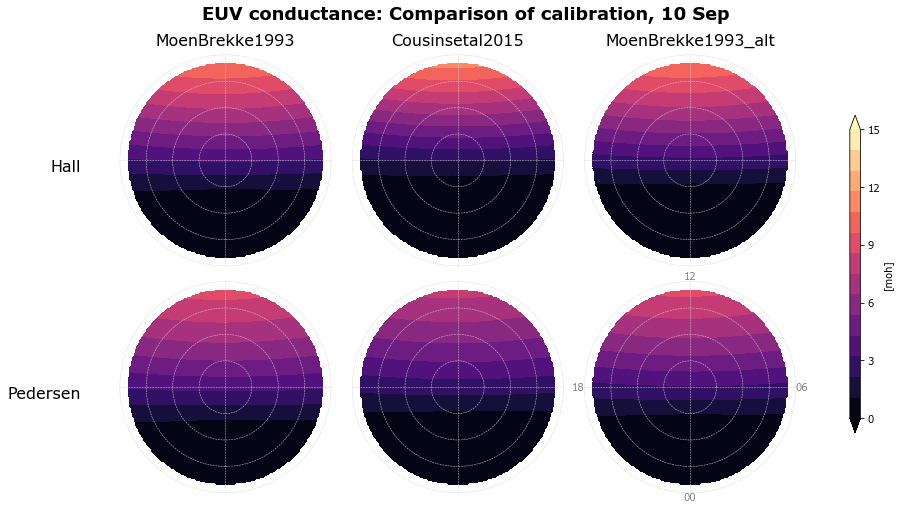

In [65]:
# set up figure and axes
fig = plt.figure(figsize=(11,7))
fig.suptitle("""EUV conductance: Comparison of calibration, """+time.strftime("%d %b")+"""             """, fontweight="bold", fontsize = 18)
axs = [fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233), fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)]
paxs = []

for ax in axs:
    paxs.append(lompe.model.visualization.Polarsubplot(ax, minlat = 50, plotgrid = True, sector = 'all'))
paxs[-1].writeMLTlabels(color='grey', mlat = 50)

# conductances from the different calibrations
levels = np.linspace(0, 15, 15)
ticks = np.linspace(0,15,6)

# Hall
paxs[0].contourf(mlat, mlt, EUV_SH.reshape(mlat.shape), cmap='magma', levels=levels, extend='both') # moenbrekke1993
paxs[1].contourf(mlat, mlt, SH_C.reshape(  mlat.shape), cmap='magma', levels=levels, extend='both') # cousinsetal2015
paxs[2].contourf(mlat, mlt, SH_alt.reshape(mlat.shape), cmap='magma', levels=levels, extend='both') # moenbrekke993_alt

# Pedersen
paxs[3].contourf(  mlat, mlt, EUV_SP.reshape(mlat.shape), cmap='magma', levels=levels, extend='both') # moenbrekke1993
paxs[4].contourf(  mlat, mlt, SP_C.reshape(  mlat.shape), cmap='magma', levels=levels, extend='both') # cousinsetal2015
c=paxs[5].contourf(mlat, mlt, SP_alt.reshape(mlat.shape), cmap='magma', levels=levels, extend='both') # moenbrekke993_alt

# add titles and adjust
paxs[0].write(35, 18.3, 'Hall',     fontsize = 16, ha = 'right')
paxs[3].write(35, 18.3, 'Pedersen', fontsize = 16, ha = 'right')
axs[0].set_title('MoenBrekke1993'    , y = 0.98, fontsize = 16)
axs[1].set_title('Cousinsetal2015'   , y = 0.98, fontsize = 16)
axs[2].set_title('MoenBrekke1993_alt', y = 0.98, fontsize = 16)
plt.subplots_adjust(hspace=0, wspace=0, left=0, right=1.1, bottom=0 ,top=.9);

# colorbar
cbar = fig.colorbar(c, ax = axs, ticks=ticks, orientation = 'vertical', label = '[moh]', shrink=.7, aspect=30)

Where the MLT labels are in the lower right hand panel.